In [1]:
from temporora import *

Processing dataset: FD001
Dataset FD001 Metrics:
Validation MSE: 0.0378, RMSE: 0.1943, R2: 0.6633
Test MSE: 599.6492, RMSE: 24.4877, R2: 0.6269


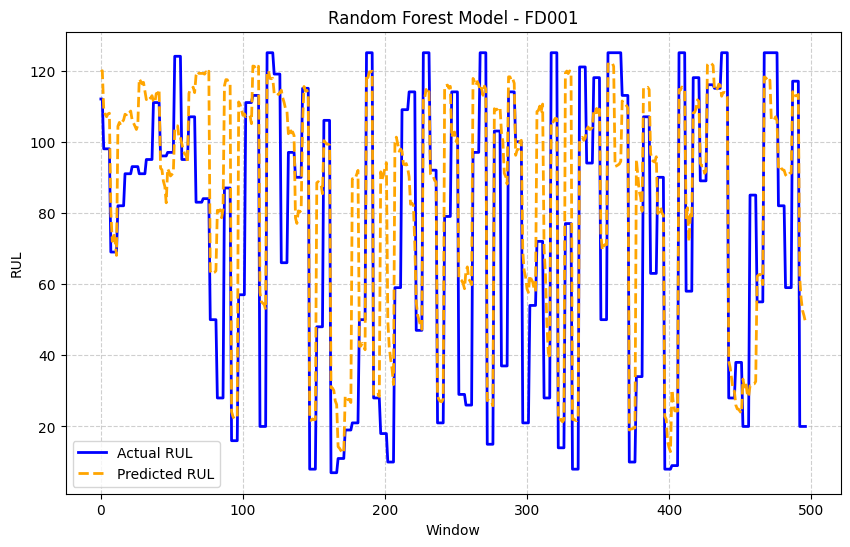

Processing dataset: FD002
Dataset FD002 Metrics:
Validation MSE: 0.0920, RMSE: 0.3033, R2: 0.1765
Test MSE: 1560.5283, RMSE: 39.5035, R2: 0.1468


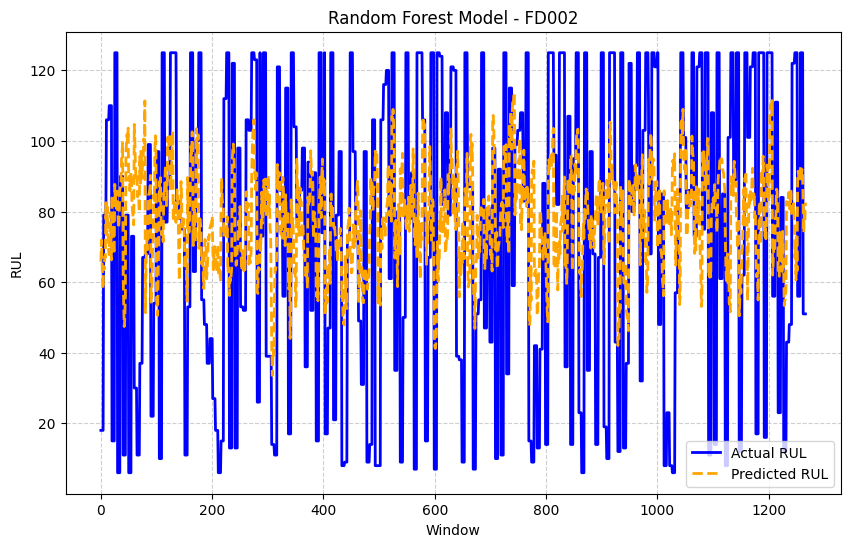

Processing dataset: FD003
Dataset FD003 Metrics:
Validation MSE: 0.0287, RMSE: 0.1695, R2: 0.7153
Test MSE: 541.3634, RMSE: 23.2672, R2: 0.6471


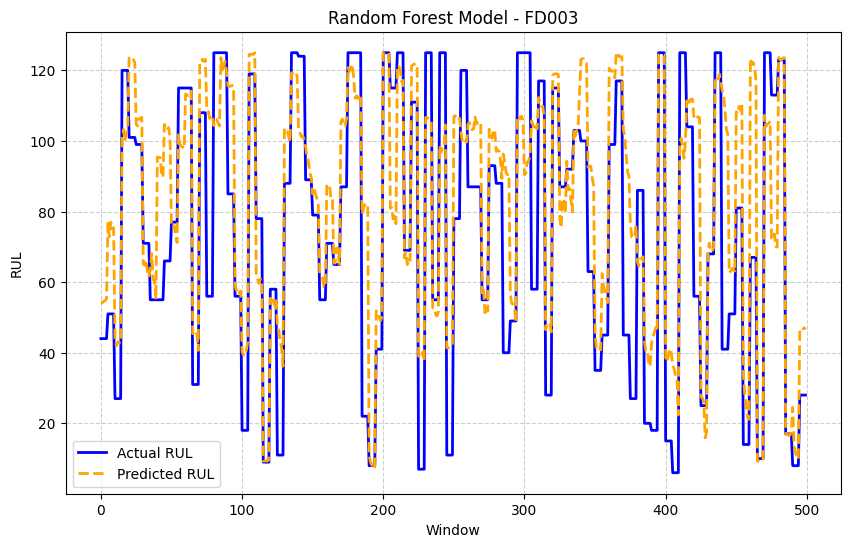

Processing dataset: FD004
Dataset FD004 Metrics:
Validation MSE: 0.0772, RMSE: 0.2779, R2: 0.3011
Test MSE: 1516.7605, RMSE: 38.9456, R2: 0.1723


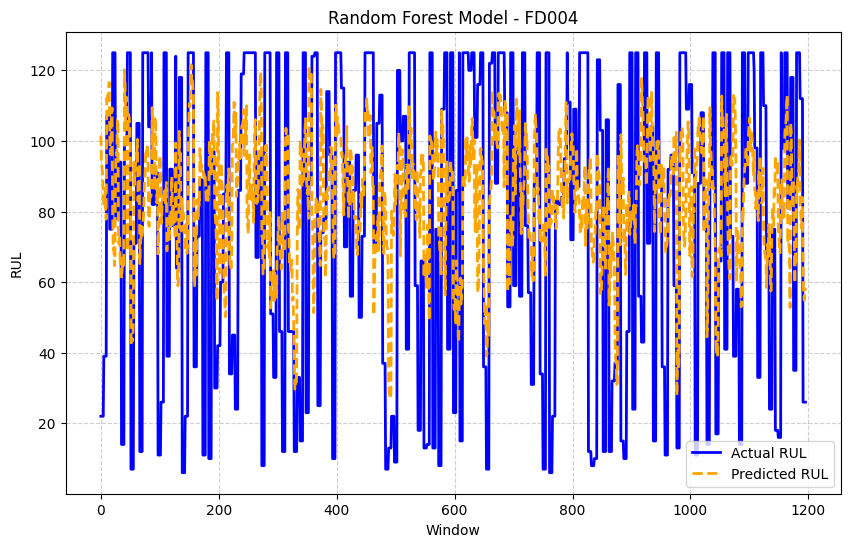

In [ ]:
# Assuming metrics is defined before this loop
for dataset in datasets:
    print(f"Processing dataset: {dataset}")
    args.sub_dataset = dataset  # Set current dataset

    train_loader, valid_loader, tQest_loader, test_loader_last, \
        num_test_windows, train_visualize, engine_id = get_dataloader(
            dir_path=args.dataset_root,
            sub_dataset=args.sub_dataset,
            max_rul=args.max_rul,
            seq_length=args.sequence_len,
            batch_size=args.batch_size,
            use_exponential_smoothing=args.use_exponential_smoothing,
            smooth_rate=args.smooth_rate)

    # Fit Random Forest Regressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust n_estimators and other params
    for i, (x, y) in enumerate(train_loader):
        x = x.view(-1, args.sequence_len * args.feature_num).numpy()
        y = y.numpy().ravel()  # Use .ravel() to flatten y to 1D
        rf_model.fit(x, y)

    # Validate and Test
    valid_predictions, valid_actuals = [], []
    test_predictions, test_actuals = [], []

    # Validation set
    for i, (x, y) in enumerate(valid_loader):
        x = x.view(-1, args.sequence_len * args.feature_num).numpy()
        y = y.numpy().ravel()  # Flatten y here as well
        preds = rf_model.predict(x)

        valid_predictions.extend(preds)
        valid_actuals.extend(y)

    # Test set
    for i, (x, y) in enumerate(test_loader):
        x = x.view(-1, args.sequence_len * args.feature_num).numpy()
        y = y.numpy().ravel()  # Flatten y here as well
        preds = rf_model.predict(x)

        test_predictions.extend(preds)
        test_actuals.extend(y)

    # Post-process predictions
    test_predictions = np.array(test_predictions)
    test_actuals = np.array(test_actuals)
    valid_predictions = np.array(valid_predictions)
    valid_actuals = np.array(valid_actuals)

    max_rul = max(test_actuals.max(), valid_actuals.max())
    test_predictions = np.clip(test_predictions, 0, max_rul)
    valid_predictions = np.clip(valid_predictions, 0, max_rul)
    test_predictions = test_predictions * args.max_rul
    test_actuals = test_actuals * args.max_rul

    # Compute Metrics
    valid_mse = mean_squared_error(valid_actuals, valid_predictions)
    valid_rmse = np.sqrt(valid_mse)
    valid_r2 = r2_score(valid_actuals, valid_predictions)

    test_mse = mean_squared_error(test_actuals, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_actuals, test_predictions)

    metrics[dataset] = {
        "Validation MSE": valid_mse,
        "Validation RMSE": valid_rmse,
        "Validation R2": valid_r2,
        "Test MSE": test_mse,
        "Test RMSE": test_rmse,
        "Test R2": test_r2
    }

    print(f"Dataset {dataset} Metrics:")
    print(f"Validation MSE: {valid_mse:.4f}, RMSE: {valid_rmse:.4f}, R2: {valid_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")

    # Inline Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(test_actuals, label='Actual RUL', color='blue', linewidth=2)
    plt.plot(test_predictions, label='Predicted RUL', color='orange', linestyle='--', linewidth=2)
    plt.xlabel('Window')
    plt.ylabel('RUL')
    plt.title(f'Random Forest Model - {dataset}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()  # Inline visualization during the loop
